In [17]:
!unzip /content/Face-Images

Archive:  /content/Face-Images.zip
  inflating: Face Images/.DS_Store   
  inflating: __MACOSX/Face Images/._.DS_Store  
  inflating: Face Images/Final Training Images/.DS_Store  
  inflating: __MACOSX/Face Images/Final Training Images/._.DS_Store  
replace Face Images/Final Training Images/face12/image_0281_Face_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
!find . -name "*.DS_Store" -type f -delete

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from PIL import Image

In [14]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

    def __len__(self):
        return sum(len(files) for _, _, files in os.walk(self.root_dir))

    def __getitem__(self, idx):
        class_idx = 0
        while idx >= len(os.listdir(os.path.join(self.root_dir, self.classes[class_idx]))):
            idx -= len(os.listdir(os.path.join(self.root_dir, self.classes[class_idx])))
            class_idx += 1
        class_dir = os.path.join(self.root_dir, self.classes[class_idx])
        file_name = os.listdir(class_dir)[idx]
        image = Image.open(os.path.join(class_dir, file_name))
        if self.transform:
            image = self.transform(image)
        return image, class_idx


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2),
            nn.Sigmoid()  # Scale pixel values to [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((231,231)),
    transforms.ToTensor()
])

traindataset = CustomDataset(root_dir='/content/Face Images/Final Training Images', transform=transform)
testdataset = CustomDataset(root_dir='/content/Face Images/Final Testing Images', transform=transform)
train = DataLoader(traindataset, batch_size=32, shuffle=True)
test = DataLoader(testdataset, batch_size=32, shuffle=True)

In [15]:
model = Autoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    for i, data in enumerate(train, 0):
        inputs, _ = data  # Assuming you don't have labels in train data
        inputs_noisy = inputs + 0.1 * torch.randn_like(inputs)  # Add Gaussian noise

        inputs_noisy, inputs = inputs_noisy.to(device), inputs.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs_noisy)  # Forward pass
        loss = criterion(outputs, inputs)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


Finished Training


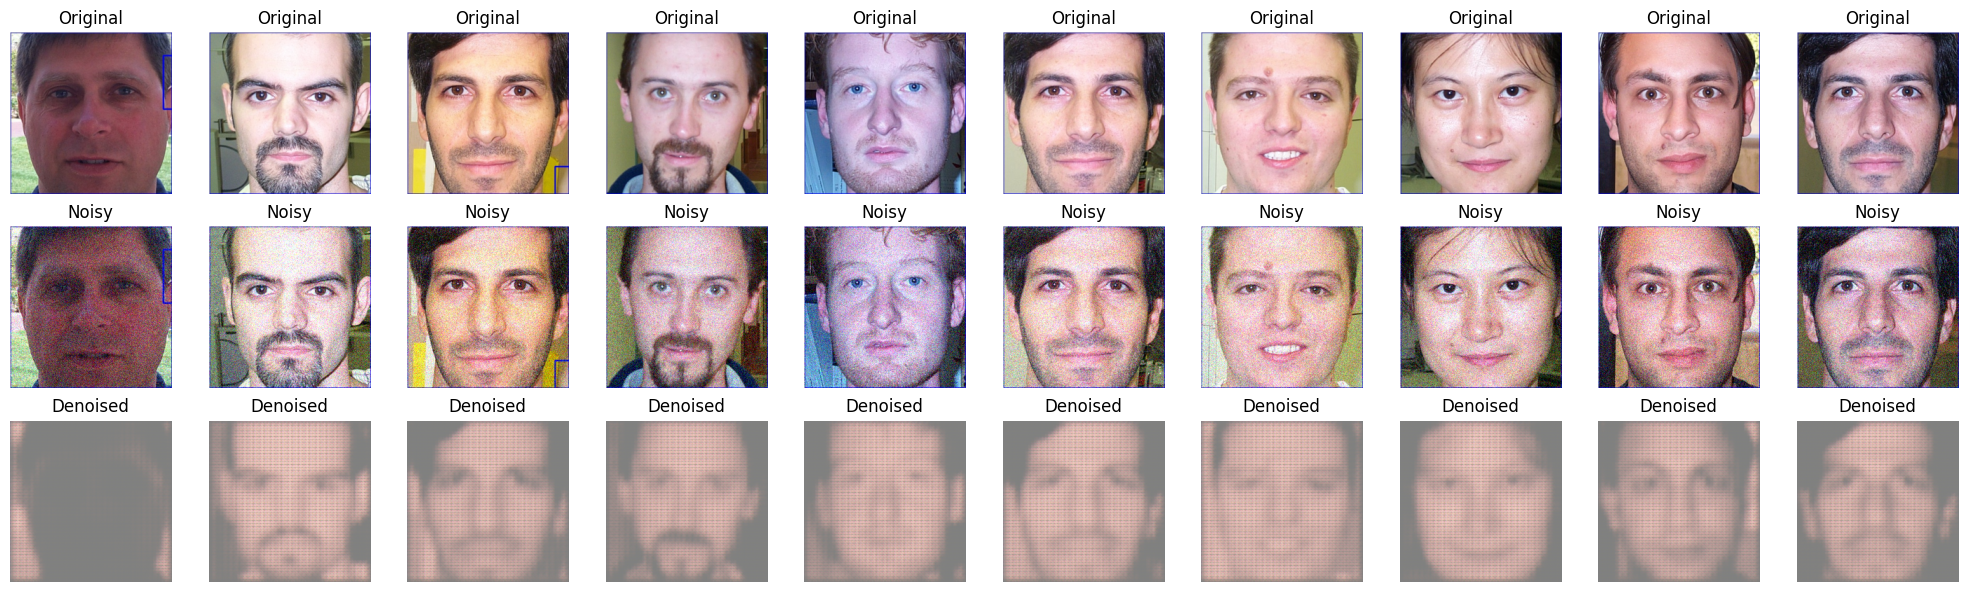

In [16]:
# Let's visualize some results
model.eval()  # Set the model to evaluation mode

test_loader = DataLoader(traindataset, batch_size=10, shuffle=True)
test_batch = next(iter(test_loader))
test_images, _ = test_batch
test_images_noisy = test_images + 0.1 * torch.randn_like(test_images)  # Add noise to test images
test_images_noisy = test_images_noisy.to(device)

# Denoise the test images
with torch.no_grad():
    denoised_images = model(test_images_noisy)

# Visualize the original, noisy, and denoised images
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))

for i in range(10):
    axes[0, i].imshow(test_images[i].permute(1, 2, 0))
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(test_images_noisy[i].permute(1, 2, 0))
    axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')

    axes[2, i].imshow(denoised_images[i].cpu().detach().permute(1, 2, 0))
    axes[2, i].set_title('Denoised')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()